**Dataset**
labeled datasset collected from twitter (Lab 1 - Hate Speech.tsv)

**Objective**
classify tweets containing hate speech from other tweets. <br>
0 -> no hate speech <br>
1 -> contains hate speech <br>


**Evaluation metric**
macro f1 score

### Global Variables :

In [1]:
RANDOM_STATE = 42
NUM_OF_EPOCHES = 20
BATCH_SIZE = 32

## Import Libraries

In [2]:
# Standard libraries
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# NLTK libraries
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Gensim library
from gensim.models import Word2Vec

# Scikit-learn libraries
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, f1_score


from tensorflow.keras.preprocessing.text import Tokenizer

from gensim.models import KeyedVectors
from tqdm import tqdm


2025-04-25 06:34:48.492732: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 06:34:48.504829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745552088.518104   52250 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745552088.521951   52250 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745552088.532904   52250 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# # Ensure NLTK resources are downloaded
# nltk.download('punkt')
# nltk.download('stopwords')

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

### Load Dataset

##### Note: search how to load the data from tsv file

In [5]:
df = pd.read_csv("Hate Speech.tsv", sep= "\t", index_col='id')
df.head(30)

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0,bihday your majesty
4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
5,0,factsguide: society now #motivation
6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
8,0,the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers â¦


Insights from the data to determine the preprossing needed:

- mentions like @user
- `#` remove
- punctiuations 
- non words like ±!!! ððð (non ascii)
- things like [2/2]
- remove numbers 


In the case of # we have 2 options :
- remove the whole # with the word after it 
- remove the # sign only 

In our case Because hashtags often hold valuable meaning (e.g., #gold, #forex, #michigan) so it can make difference.



In [6]:
df_copy = df.copy()

### Data splitting

It is a good practice to split the data before EDA helps maintain the integrity of the machine learning process, prevents data leakage, simulates real-world scenarios more accurately, and ensures reliable model performance evaluation on unseen data.

In [7]:
X = df.drop(columns=['label'])
y = df['label']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
train_combined = pd.concat([x_train, y_train], axis=1)
test_combined = pd.concat([x_test, y_test], axis=1)

train_combined.drop_duplicates(inplace=True)
test_combined.drop_duplicates(inplace=True)
X_train = train_combined.drop('label', axis=1)
y_train = train_combined['label']
X_test = test_combined.drop('label', axis=1)
y_test = test_combined['label']

In [9]:
X_train.head()

,tweet
id,
9414,"@user @user would like to wish you a #father's day :), #family #dad #fathersday"
17664,always enjoy life! and be grateful for what you have #mondaymotivation #2016
438,"kayak, sup, snorkel, swim...whatever your pleasure, we'll put it together! #alohabeachbus #hawaii #explore"
21957,@user what do you think of #alexjones saying #draintheswamp? #populationcontrol you had good videos with him. they got him.
16373,well i guess i can't join servers mcpe 15.0. #mcpe #mcpc #weird


### EDA on training data

- check NaNs

In [10]:
train_combined.isnull().sum()

tweet    0
label    0
dtype: int64

- check duplicates

In [11]:
train_combined.duplicated().sum()

0

- show a representative sample of data texts to find out required preprocessing steps

In [12]:
train_combined.head(20)

,tweet,label
id,,
9414,"@user @user would like to wish you a #father's day :), #family #dad #fathersday",0
17664,always enjoy life! and be grateful for what you have #mondaymotivation #2016,0
438,"kayak, sup, snorkel, swim...whatever your pleasure, we'll put it together! #alohabeachbus #hawaii #explore",0
21957,@user what do you think of #alexjones saying #draintheswamp? #populationcontrol you had good videos with him. they got him.,1
16373,well i guess i can't join servers mcpe 15.0. #mcpe #mcpc #weird,0
12586,trumps associates are a classy bunch.,1
5045,now playing #intwine - on classic rock attic,0
448,"if lewis remains perfect, the rangers announcers are gonna stroke out.",0
2339,cool treat on a hot hot day ð§ #widn #frozenyogu tuesday #dclife #summer #gogreenâ¦,0


- check dataset balancing

In [13]:
# check the distribution of the labels
train_combined['label'].value_counts()

label
0    21834
1     1600
Name: count, dtype: int64

<Axes: title={'center': 'Label Distribution'}, xlabel='label'>

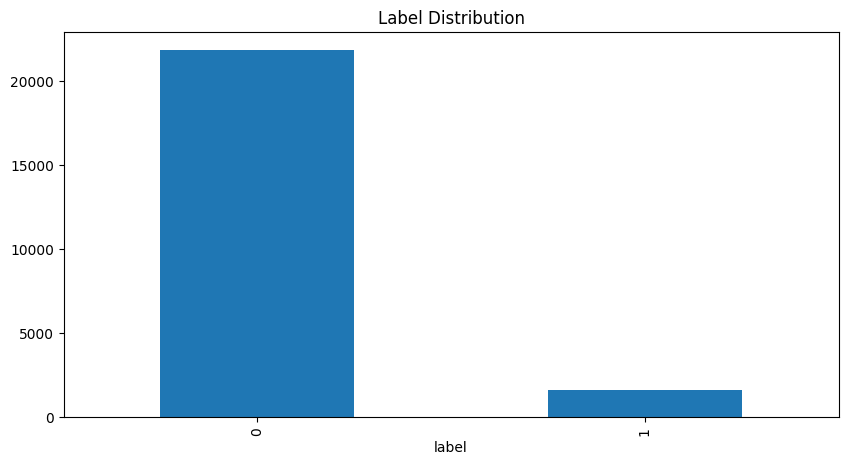

In [14]:
train_combined['label'].value_counts().plot(kind='bar', title='Label Distribution', figsize=(10, 5))

Data is unbalanced

- Cleaning and Preprocessing are:
    - 1
    - 2
    - 3
    - ... etc.

### Cleaning and Preprocessing

#### Extra: use custom scikit-learn Transformers

Using custom transformers in scikit-learn provides flexibility, reusability, and control over the data transformation process, allowing you to seamlessly integrate with scikit-learn's pipelines, enabling you to combine multiple preprocessing steps and modeling into a single workflow. This makes your code more modular, readable, and easier to maintain.

##### link: https://www.andrewvillazon.com/custom-scikit-learn-transformers/

#### Example usage:

In [15]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 fix_encoding=True, 
                 remove_hashtags=True, 
                 remove_mentions=True, 
                 remove_punctuation=True, 
                 lowercase=True, 
                 remove_stopwords=True, 
                 remove_urls=True, 
                 lemmatize=False, 
                 stem=True,
                 replace_slang=True,
                 remove_numbers=True,
                 remove_stock_symbols=True):
        
        self.fix_encoding = fix_encoding
        self.remove_hashtags = remove_hashtags
        self.remove_mentions = remove_mentions
        self.remove_punctuation = remove_punctuation
        self.lowercase = lowercase
        self.remove_stopwords = remove_stopwords
        self.remove_urls = remove_urls
        self.lemmatize = lemmatize
        self.stem = stem
        self.replace_slang = replace_slang
        self.remove_numbers = remove_numbers
        self.remove_stock_symbols = remove_stock_symbols
        
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        if not isinstance(text, str):
            return ''
        
        if self.fix_encoding:
            text = self._fix_encoding(text)
        if self.lowercase:
            text = text.lower()
        if self.replace_slang:
            text = self._replace_slang(text)
        if self.remove_urls:
            text = self._remove_urls(text)
        if self.remove_hashtags:
            text = self._remove_hashtags(text)
        if self.remove_mentions:
            text = self._remove_mentions(text)
        if self.remove_punctuation:
            text = self._remove_punctuation(text)
        if self.remove_numbers:
            text = re.sub(r'\d+', '', text)
        if self.remove_stock_symbols:
            text = re.sub(r'\$\w+', '', text)

        words = text.split()
        if self.remove_stopwords:
            words = [w for w in words if w not in self.stop_words]
        if self.lemmatize:
            words = [self.lemmatizer.lemmatize(w) for w in words]
        if self.stem:
            words = [self.stemmer.stem(w) for w in words]

        return ' '.join(words)

    def _fix_encoding(self, text):
        return text.encode("ascii", "ignore").decode()

    def _replace_slang(self, text):
        slang_dict = {
            r'\bur\b': 'your',
            r'\bu\b': 'you',
            r'\bgr8\b': 'great',
            r'\b4u\b': 'for you',
            # r'\blol\b': 'laughing out loud'
        }
        for slang, replacement in slang_dict.items():
            text = re.sub(slang, replacement, text)
        return text
    

    def _remove_urls(self, text):
        return re.sub(r'https?://\S+|www\.\S+', '', text)

    def _remove_hashtags(self, text):
        return re.sub(r'#', '', text)
    
    def _remove_mentions(self, text):
        return re.sub(r'@\w+', '', text)
    
    def _remove_punctuation(self, text):
        return re.sub(r'[^\w\s]', '', text)


In [16]:
train_combined['tweet'].apply(lambda x: len(x.split())).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count    23434.000000
mean        13.522275
std         20.073546
min          1.000000
25%          9.000000
50%         13.000000
75%         17.000000
90%         21.000000
95%         23.000000
99%         26.000000
max       2607.000000
Name: tweet, dtype: float64


#### most of the sentences length is 26 word and there is an outline with 2607 

- I will set max_len = 30 because it is a good balance as it:

1. Covers nearly all data

2. Avoids wasting memory on rare long outliers

3. Keeps model efficient

In [17]:
class TextTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self, num_words=50_000, oov_token="<OOV>"):
        self.num_words = num_words
        self.oov_token = oov_token
        self.tokenizer = None

    def fit(self, X):
        self.tokenizer = Tokenizer(num_words=self.num_words, oov_token=self.oov_token)
        self.tokenizer.fit_on_texts(X)
        return self

    def transform(self, X):
        return self.tokenizer.texts_to_sequences(X)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

**You  are doing Great so far!**

### Modelling

#### Extra: use scikit-learn pipline

##### link: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Using pipelines in scikit-learn promotes better code organization, reproducibility, and efficiency in machine learning workflows.

#### Example usage:

In [18]:
tokenizer = TextTokenizer(num_words=50_000, oov_token="<OOV>")
X_train_tokenized = tokenizer.fit_transform(X_train['tweet'])
X_test_tokenized = tokenizer.transform(X_test['tweet'])

In [33]:
def load_glove_embeddings(file_path, tokenizer):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe embeddings"):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    word_index = word_index = tokenizer.tokenizer.word_index

    embedding_matrix = np.zeros((len(word_index) + 1, 100))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_fasttext_embeddings(file_path, tokenizer):
    embeddings_index = {}
    with open(file_path, 'rb') as f:
        for line in tqdm(f, desc="Loading FastText embeddings"):
            values = line.split()
            word = values[0].decode('utf-8')
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    word_index = word_index = tokenizer.tokenizer.word_index

    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

def load_word2vec_embeddings(file_path, tokenizer):
    word2vec = KeyedVectors.load_word2vec_format(file_path, binary=True)
    word_index = word_index = tokenizer.tokenizer.word_index

    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        if word in word2vec:
            embedding_matrix[i] = word2vec[word]
    return embedding_matrix


glove_embeddings = load_glove_embeddings('glove.6B.100d.txt', tokenizer)

fasttext_embeddings = load_fasttext_embeddings('cc.en.300.vec', tokenizer)

FileNotFoundError: [Errno 2] No such file or directory: 'glove.6B.100d.txt'

In [16]:
# from sklearn.pipeline import Pipeline

# model = LogisticRegression()

# # Create the pipeline
# pipeline = Pipeline(steps=[
#     ('preprocessing', CustomTransformer()),
#     ('Vectorizing', Vectorizer()),
#     ('model', model),
# ])

# # Now you can use the pipeline for training and prediction
# # pipeline.fit(X_train, y_train)
# # pipeline.predict(X_test)

In [17]:
model = LogisticRegression(max_iter=1000)

In [18]:
pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor()),
    ('Vectorizing', TfidfVectorizer()),
    ('model', model),
])

In [19]:
pipeline.fit(df_train['tweet'], df_train['label'])

Pipeline(steps=[('preprocessing', TextPreprocessor()),
                ('Vectorizing', TfidfVectorizer()),
                ('model', LogisticRegression(max_iter=1000))])

In [20]:
predictions = pipeline.predict(df_test['tweet'])

In [21]:
print(classification_report(df_test['label'], predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5875
           1       0.89      0.31      0.46       432

    accuracy                           0.95      6307
   macro avg       0.92      0.65      0.72      6307
weighted avg       0.95      0.95      0.94      6307



`Note :`
### Impact of Class Weights:
- Class Weight balanced: This helps the model give more importance to the minority class (label=1), making it more likely to predict the minority class, thus improving recall for that class.

- Without class weights: The model is biased towards the majority class (label=0), leading to a very high recall for the majority class and very low recall for the minority class, which was observed in your earlier results.

#### Evaluation

**Evaluation metric:**
macro f1 score

Macro F1 score is a useful metric in scenarios where you want to evaluate the overall performance of a multi-class classification model, **particularly when the classes are imbalanced**

![Calculation](https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/639c3d934e82c1195cdf3c60_macro-f1.webp)

In [22]:
# macro f1 score
f1_macro = f1_score(df_test['label'], predictions, average='macro')
print("Macro F1 Score:", f1_macro)

Macro F1 Score: 0.7153906878335893


In [34]:
# Try with class weights
model = LogisticRegression(class_weight='balanced', max_iter=1000)

pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor()),
    ('Vectorizing', TfidfVectorizer()),
    ('model', model),
])

pipeline.fit(df_train['tweet'], df_train['label'])

predictions = pipeline.predict(df_test['tweet'])

print(classification_report(df_test['label'], predictions))

# macro f1 score
f1_macro = f1_score(df_test['label'], predictions, average='macro')
print("Macro F1 Score:", f1_macro)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      5875
           1       0.56      0.81      0.67       432

    accuracy                           0.94      6307
   macro avg       0.78      0.88      0.82      6307
weighted avg       0.96      0.94      0.95      6307

Macro F1 Score: 0.818105785314645


### Enhancement

- Using different vectorizers with different hyperparameters
- Trying different ML models and doing hyperparameter tuning

`Note`

- You cannot use Word2Vec directly in the pipeline because it doesn't follow the Scikit-learn interface required for pipeline steps. Specifically, Scikit-learn expects each step in the pipeline (except the final estimator) to be a transformer that implements the fit and transform methods.

- However, Word2Vec does not have a transform() method. It has a `wv` attribute to access word vectors, but there is no direct way to transform text into vectors using a simple function like transform().


In [31]:
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count

    def fit(self, X, y=None):
        sentences = [tweet.split() for tweet in X]  # Tokenize each tweet
        self.model = Word2Vec(sentences, vector_size=self.vector_size, window=self.window, min_count=self.min_count)
        return self

    def transform(self, X):
        embeddings = []
        for tweet in X:
            words = [self.model.wv[word] for word in tweet.split() if word in self.model.wv]
            if words:
                tweet_vec = np.mean(words, axis=0)
            else:
                tweet_vec = np.zeros(self.vector_size)  # Handle empty tweets
            embeddings.append(tweet_vec)
        return np.array(embeddings)

In [36]:
# Try using Word2Vec for vectorization
pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor()),
    ('Vectorizing', Word2VecTransformer()),
    ('model', model),
])

pipeline.fit(df_train['tweet'], df_train['label'])

predictions = pipeline.predict(df_test['tweet'])

print(classification_report(df_test['label'], predictions))

# macro f1 score
f1_macro = f1_score(df_test['label'], predictions, average='macro')
print("Macro F1 Score:", f1_macro)

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      5875
           1       0.17      0.79      0.28       432

    accuracy                           0.72      6307
   macro avg       0.58      0.75      0.55      6307
weighted avg       0.92      0.72      0.79      6307

Macro F1 Score: 0.5546719058287899


In [55]:
# # Try Glove
# from sklearn.base import BaseEstimator, TransformerMixin
# from gensim.models import KeyedVectors
# import numpy as np

# class GloVeTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, vector_size=100):
#         self.glove_file = 'glove.6B/glove.6B.100d.txt'  # Path to your GloVe file

#         self.vector_size = vector_size
#         self.word_vectors = None

#     def fit(self, X, y=None):
#         # Load GloVe word vectors
#         self.word_vectors = KeyedVectors.load_word2vec_format(self.glove_file, binary=False)
#         return self

#     def transform(self, X):
#         embeddings = []
#         for tweet in X:
#             words = [self.word_vectors[word] for word in tweet.split() if word in self.word_vectors]
#             if words:
#                 tweet_vec = np.mean(words, axis=0)
#             else:
#                 tweet_vec = np.zeros(self.vector_size)  # Handle empty tweets
#             embeddings.append(tweet_vec)
#         return np.array(embeddings)
    
# # Example usage
# # glove_file = 'glove.6B/glove.6B.100d.txt'  # Path to your GloVe file
# pipeline = Pipeline(steps=[
#     ('preprocessing', TextPreprocessor()),
#     ('Vectorizing', GloVeTransformer()),
#     ('model', model),
# ])

# pipeline.fit(df_train['tweet'], df_train['label'])

# predictions = pipeline.predict(df_test['tweet'])

# print(classification_report(df_test['label'], predictions))

# # macro f1 score
# f1_macro = f1_score(df_test['label'], predictions, average='macro')
# print("Macro F1 Score:", f1_macro)


In [49]:
# SVM model
from sklearn.svm import SVC

model = SVC(kernel='linear', class_weight='balanced', max_iter=1000)

pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor()),
    ('Vectorizing', Word2VecTransformer()),
    ('model', model),
])

pipeline.fit(df_train['tweet'], df_train['label'])

predictions = pipeline.predict(df_test['tweet'])

print(classification_report(df_test['label'], predictions))

# macro f1 score
f1_macro = f1_score(df_test['label'], predictions, average='macro')
print("Macro F1 Score:", f1_macro)

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      5875
           1       0.17      0.82      0.28       432

    accuracy                           0.71      6307
   macro avg       0.57      0.76      0.55      6307
weighted avg       0.93      0.71      0.78      6307

Macro F1 Score: 0.5455017009546693


In [59]:
from sklearn.feature_extraction.text import CountVectorizer

class BagOfWordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.vectorizer = CountVectorizer()
        
    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self
    
    def transform(self, X):
        return self.vectorizer.transform(X).toarray()
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
    

In [60]:
# Example usage
pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor()),
    ('Vectorizing', BagOfWordsTransformer()),
    ('model', model),
])

pipeline.fit(df_train['tweet'], df_train['label'])

predictions = pipeline.predict(df_test['tweet'])

print(classification_report(df_test['label'], predictions))
# macro f1 score
f1_macro = f1_score(df_test['label'], predictions, average='macro')
print("Macro F1 Score:", f1_macro)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5875
           1       0.63      0.77      0.69       432

    accuracy                           0.95      6307
   macro avg       0.81      0.87      0.83      6307
weighted avg       0.96      0.95      0.96      6307

Macro F1 Score: 0.833624942665119


In [88]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import classification_report, f1_score

# Tokenization
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df_train['tweet'])

X_train = tokenizer.texts_to_sequences(df_train['tweet'])
X_test = tokenizer.texts_to_sequences(df_test['tweet'])

# Padding
X_train = pad_sequences(X_train, maxlen=100)
X_test = pad_sequences(X_test, maxlen=100)

y_train = df_train['label']
y_test = df_test['label']

# Model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)

# Evaluation
print(classification_report(y_test, predictions))
f1_macro = f1_score(y_test, predictions, average='macro')
print("Macro F1 Score:", f1_macro)


Epoch 1/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9239 - loss: 0.3007
Epoch 2/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9319 - loss: 0.1695
Epoch 3/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9559 - loss: 0.1234
Epoch 4/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9572 - loss: 0.1064
Epoch 5/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9635 - loss: 0.0948
Epoch 6/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9643 - loss: 0.0870
Epoch 7/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9646 - loss: 0.0844
Epoch 8/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9635 - loss: 0.0861
Epoch 9/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9632 - loss: 0.0865
Epoch 10/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9630 - loss: 0.0886
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98

### Conclusion and final results


In [61]:
pipeline = Pipeline(steps=[
    ('preprocessing', TextPreprocessor()),
    ('Vectorizing', BagOfWordsTransformer()),
    ('model', model),
])

pipeline.fit(df_train['tweet'], df_train['label'])

predictions = pipeline.predict(df_test['tweet'])

print(classification_report(df_test['label'], predictions))
# macro f1 score
f1_macro = f1_score(df_test['label'], predictions, average='macro')
print("Macro F1 Score:", f1_macro)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5875
           1       0.63      0.77      0.69       432

    accuracy                           0.95      6307
   macro avg       0.81      0.87      0.83      6307
weighted avg       0.96      0.95      0.96      6307

Macro F1 Score: 0.833624942665119


`Note :` 
- That is the best result the best model and the vectorizer 
- Or the CNN model too 

#### The Results :
- The model performs excellently in classifying the `majority` class `0`, with high precision, recall, and F1-score. However, the performance for the `minority` class `1` is weaker, with a lower precision and F1-score. This discrepancy could be due to class imbalance, as class 0 has significantly more instances than class 1. The overall accuracy and macro F1 score indicate that the model is generally effective but could benefit from techniques to improve classification for the minority class, such as oversampling, undersampling, or using advanced class-balancing methods.

#### Done!